In [150]:
import os
import sys
import datetime
import numpy as np
import yaml
import pandas as pd
import os.path
import time


core_count = 5
num_vals = 100
batch_num = 0

train = "train"
ac_flag = True
fc_flag = True
pc_flag = True
small_flag = False

batch_num = 2

name = train + str(ac_flag) + str(fc_flag) + str(pc_flag) + str(small_flag) + str(batch_num)

yaml_loc = "yamls_" + name + "/" #train ac_flag fc_flag pc_flag small_flag batch_num
out_dir = "results_" + name + "/"
#

params = ["N_c_mult", "T_c", "sig2_mult","gamma","lamb","prior_cov_mult"]

master_param_val_yaml = "master.yaml"


with open(master_param_val_yaml) as f:
    master_param_vals =  yaml.load(f)

master_param_vals = {"N_c_mult": 0.5,
  "T_c":5,
  "sig2_mult":1.,
  "gamma":0.9,
  "lamb":1.,
  "prior_cov_mult":0.5,
  "sim_seed": 735063209,
  "split_seed": 1642177786,
  "batch_num": batch_num,
  "train": True,
  "k": 3,
  "prior_mean": None,
  "resid_sig2": None,
  "sim_num": 0,
  "ac_flag":ac_flag,
  "fc_flag":fc_flag,
  "pc_flag":pc_flag,
  "small_flag":small_flag
  }

min_param_vals = {"N_c_mult": 0.05,
              "T_c":3,
              "sig2_mult":0.10,
              "gamma":0.,
              "lamb":0.1,
              "prior_cov_mult":0.10
}

max_param_vals = {"N_c_mult": 0.9,
              "T_c":70,
              "sig2_mult":10.,
              "gamma":1.,
              "lamb":10.,
              "prior_cov_mult":10.
}

num_run_through = 3



sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])
sim_param_vals.loc[:,:] = np.nan

sim_num = 0

for run_through in range(num_run_through):
    for param in params:
        print("Started " + str(run_through) + " " + param + " " + str(datetime.datetime.now()))
        
        start_sim_num = sim_num

        param_space = np.linspace(min_param_vals[param], max_param_vals[param],num=num_vals)
        if param == "T_c":
            param_space = param_space.round()
        for param_val,val_num in zip(param_space,range(num_vals)):
            param_vals = master_param_vals.copy()
            param_vals[param] = param_val
            param_vals["sim_num"] = sim_num

            ## Write param_vals to yaml ##
            with open(yaml_loc + "params" + str(val_num) + ".yaml","w") as f:
                yaml.dump(param_vals, f)
            
            # Save sim_params
            sim_param_vals.iloc[sim_num,:len(params)] = [param_vals[param] for param in params]
            sim_num += 1

        
    
        # Update master_param_vals based on optimum #
        for param_val,sim_num_done in zip(param_space, range(start_sim_num,sim_num)):
            regret_file = out_dir + "regret_simNum" + str(sim_num_done) + ".npy"
            
            ## WAITING CODE ##
            while not os.path.exists(regret_file):
                time.sleep(30)
                print("Waiting for " + str(regret_file))
                
            if not os.path.isfile(file_path):
                raise ValueError("%s isn't a file!" % regret_file)

            regret = np.load(regret_file)
            sim_param_vals.loc[sim_num_done,"Mean"] = np.nanmean(regret,axis=1).mean()
            sim_param_vals.loc[sim_num_done,"Std"] = np.nanmean(regret,axis=1).std()
            
            
        sim_num_max = sim_param_vals.loc[start_sim_num:sim_num,"Mean"].idxmax()
        master_param_vals[param] = sim_param_vals.loc[sim_num_max,param]
        print(param + " opt val: " + master_param_vals)
        sim_param_vals.to_csv(out_dir + "sim_param_vals.csv")
        


with open(master_param_val_yaml, "w") as f:
    yaml.dump(master_param_vals, f)


In [220]:
import datetime
from hs_test_funcs import *
import numpy as np
import datetime
import yaml
import os
import sys


'''
Read in:
'''
def run_sim(job_num, out_dir, data_loc_pref, param_loc, ac_flag = None, fc_flag = None, pc_flag = None, small_flag = None):
    # python hs_test_runner.py <job_num> <out_dir> <data_loc_pref> <param_loc> <ac_flag> <fc_flag> <pc_flag> <small_flag>

    if not os.path.exists(os.path.dirname(out_dir)):
        try:
            os.makedirs(os.path.dirname(out_dir), exist_ok=True)
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST and os.path.isdir(out_dir):
                pass
            else:
                raise



    def f_baseline_small(featVec):
        return featVec[...,[0,3,4,5,6]]

    def f_interact_small(featVec):
        return featVec[...,[0,1,2]]


    def f_baseline_identity(featVec):
        return featVec

    def f_interact_identity(featVec):
        return featVec[...,:4]

    # Load parameters
    with open(param_loc + "/params" + str(job_num) + ".yaml") as f:
        params = yaml.load(f)

    locals().update(params)


    # Generative Model fit


    #Create a reward function from true coefficients, with residuals non-mandatory
    def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
        '''Generalized reward function, can edit for different generative models.
        Works for multidimensional eta, a, and s, so long as they are of same multidimension.
        Assumes s has first element as bias for the regression.

        Resid must be passed in if not single dim.
        If single dim, can speed out without np.take.'''


        predictors = np.concatenate([A * f_interact(S), f_baseline(S)], 0)

        Theta = np.concatenate([coef1, coef0])

        if resid is None:
            resid = 0

        return(resid + np.dot(predictors, Theta))



    ## Creating Simulations



    # Counts from HS 1
    N_data = 48 # users indexed up to 48, but true count is 37
    N = 37
    T = 42
    t = 5
    nFeatures = 1+7
    nBaseline_identity = 1+7
    nInteract_identity = 1+3 # Add 1 for bias term
    nBaseline_small = 1+4
    nInteract_small = 1+2 # Add 1 for bias term

    N_sim = 500
    T_new = 90

    # start = datetime.datetime.now()

    S, R, A = read_data(N_data, T, t, nFeatures, data_loc_pref)


    ##########################
    ## SET BANDIT MODEL ##
    ##########################
    if small_flag:
        f_interact = f_interact_small
        f_baseline = f_baseline_small
        nInteract = nInteract_small
        nBaseline = nBaseline_small
    else:
        f_interact = f_interact_identity
        f_baseline = f_baseline_identity
        nInteract = nInteract_identity
        nBaseline = nBaseline_identity




    # ###############
    # ## Non-split ##
    # ###############
    # resids, Thetas_fit, resid_model = resid_regression(N, T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R, A, S)
    # resids_new, A_new, S_new = sample_sim_users(resids, A, S, N_sim, T, t)
    # I_new = np.expand_dims(~np.isnan(S_new).any(axis=-1),-1).astype(int) #



    # resid_sig2 = np.nanvar(resids)
    # prior_mean = Thetas_fit



    # prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
    # fc_params = [lamb, int(N_c_mult*T_c), T_c]


    # # sim_start = datetime.datetime.now()
    # # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)
    # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)



    ##################################
    ## Split train and test batches ##
    ##################################
    train_zip, test_zip = k_fold_split(S,R,A,k,seed = split_seed) ## Seed for split

    S_train,R_train,A_train = train_zip[batch_num]


    resids_train, Thetas_fit_train, resid_model_train = resid_regression(S_train.shape[0], T, t, nBaseline_identity, nInteract_identity, f_baseline_identity, f_interact_identity, R_train.squeeze(), A_train, S_train)
    _, Thetas_fit_bandit_train, _ = resid_regression(S_train.shape[0], T, t, nBaseline, nInteract, f_baseline, f_interact, R_train.squeeze(), A_train, S_train)
    # First Thetas_fit is for the true generative model, second is for the bandit model

    resids_new_train, A_new_train, S_new_train = sample_sim_users(resids_train, A_train, S_train, N_sim, T, t)
    I_new_train = np.expand_dims(~np.isnan(S_new_train).any(axis=-1),-1).astype(int) #

    if train:
        resid_sig2 = np.nanvar(resids_train)
        prior_mean = np.zeros(nInteract+nBaseline)


    prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
    fc_params = [lamb, int(N_c_mult*T_c), T_c]


    # sim_start = datetime.datetime.now()
    # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

    regret, prob, action, opt, fc_invoked, theta_mse, bandit = run_simulation(coef0 = Thetas_fit_train[nInteract_identity:nInteract_identity+nBaseline_identity], coef1 = Thetas_fit_train[0:nInteract_identity], nInteract = nInteract, nBaseline = nBaseline, S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline, f_interact=f_interact, f_baseline_identity=f_baseline_identity, f_interact_identity=f_interact_identity, reward_func = reward_func_general, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed, ac_flag = ac_flag, fc_flag = fc_flag, pc_flag = pc_flag, Thetas_fit_bandit = Thetas_fit_bandit_train)


    #################
    ## Output Data ##
    #################

    # datNames = ["reward_exp","reward_0","reward_1","prob","action","fc_invoked","bandit_mean"]
    # dats = [reward_exp,reward_0,reward_1,prob,action,fc_invoked,bandit_mean]

    # Without bandit_mean
    datNames = ["regret","prob","action","opt","fc_invoked","theta_mse"]
    dats = [regret,prob,action,opt,fc_invoked,theta_mse]

    for dat, datName in zip(dats, datNames):
        np.save(out_dir + datName + "_simNum" + str(sim_num) + ".npy", dat)


    #################
    ## Save Params ##
    #################
    # if train:
    #     params["computed"] = True
    #     params["prior_mean"] = Thetas_fit_bandit_train.tolist()
    #     params["resid_sig2"] = float(resid_sig2)
    #     params["train"] = False
    #     with open(param_loc + "/params" + str(job_num) + ".yaml", "w") as f:
    #         yaml.dump(params, f)


C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
test_exec.py $core_count $core_num $num_vals $tot_runs yamls_$train$ac$fc$pc$small$batch_num/ results_$train$ac$fc$pc$small$batch_num/ ~/HS_data/ hs_test_runner.py

In [ ]:
sbatch --array=0-5 --export=num_vals=6,tot_runs=1,ac=1,fc=1,pc=1,small=1,train=train script_test.slurm

In [174]:
# Batch runner

import os
import sys
import datetime


# assert len(sys.argv) >= 5


core_count = int(sys.argv[1])
core_num = int(sys.argv[2])
num_vals = int(sys.argv[3])
tot_runs = int(sys.argv[4])
test_name = sys.argv[5]
yaml_loc = sys.argv[6]
out_dir = sys.argv[7]
data_loc_pref = sys.argv[8]
script_name = sys.argv[9]


core_count = 5
num_vals = 10
tot_runs = 20 # Num 
core_num = 0
test_name = "0001"
yaml_loc = "yamls_train11112/"
out_dir = "results_train11112/"
data_loc_pref = "~/HS_data/"
script_name = "hs_test_runner.py"

# Test_name


for _ in range(tot_runs):    
    for val_num in range(core_num,num_vals,core_count):
        yaml_file = yaml_loc + "params" + str(val_num) + ".yaml"
        print(yaml_file)
        
        ## WAITING CODE ##
        '''
        while not os.path.exists(yaml_file):
            time.sleep(30)
            print("Waiting for " + str(yaml_file) + " " + str(datetime.datetime.now()))

        if not os.path.isfile(file_path):
            raise ValueError("%s isn't a file!" % yaml_file)
           ''' 
        ####Execute File for Yaml####
        command = "python " + script_name + " " + str(val_num) + " " + out_dir + " "  + data_loc_pref + " " + yaml_loc
        print(command)
#         os.system(command)

yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_runner.py 5 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params0.yaml
python hs_test_runner.py 0 results_train11112/ ~/HS_data/ yamls_train11112/
yamls_train11112/params5.yaml
python hs_test_r

In [156]:
yaml.dump?

In [139]:
sim_param_vals.to_csv()

6

In [209]:
regret = np.load("C:/Users/isaac/Downloads/results_train11112/regret_simNum0.npy")
prob = np.load("C:/Users/isaac/Downloads/results_train11112/prob_simNum0.npy")
action = np.load("C:/Users/isaac/Downloads/results_train11112/action_simNum0.npy")
opt = np.load("C:/Users/isaac/Downloads/results_train11112/opt_simNum0.npy")
fc_invoked = np.load("C:/Users/isaac/Downloads/results_train11112/fc_invoked_simNum0.npy")
theta_mse = np.load("C:/Users/isaac/Downloads/results_train11112/theta_mse_simNum0.npy")

In [221]:
for sim_num in range(6):
    regret = np.load("C:/Users/isaac/Downloads/results_train11112/regret_simNum" + str(sim_num) + ".npy")

In [226]:
np.nanmean(regret,axis=1)[0]

-0.13829685869966635

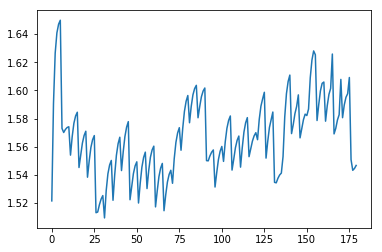

In [216]:
pd.DataFrame(theta_mse.T).mean(axis=1).plot()

In [208]:
rew

array([-0.6029349 ,  0.0959417 , -0.39458578,  0.08928495, -0.63127856,
        0.0741787 , -0.68724525, -0.37462806, -0.39033645,  0.07240679,
        0.07180896,  0.07244344,  0.07609591,  0.07355523,  0.07128365,
       -0.56644179, -0.62687142,  0.07149769, -0.41379126,  0.07898909,
        0.08122631, -0.47342457,  0.09282074, -0.50939486, -0.58131209,
        0.09209089,  0.07466743,  0.07724601,  0.07995064, -0.5493391 ,
       -0.54415449, -0.27721099, -0.51045821,  0.07396692, -0.54985004,
        0.07781286, -0.29973259,  0.07543038,  0.09583378, -0.24532654,
        0.08130021,  0.1131966 , -0.63521284,  0.08919869,  0.0845325 ,
       -0.49015605, -0.45523928, -0.63284759,  0.08282613,  0.12750644,
       -0.53019871, -0.37017674,  0.16024485,  0.11293189,  0.1637473 ,
        0.12563702, -0.52099944,  0.09927085, -0.22665662, -0.3952046 ,
        0.07915429, -0.54377892, -0.37332238, -0.61884209, -0.41535644,
       -0.45265579, -0.55988305,  0.1523688 , -0.22174948, -0.63

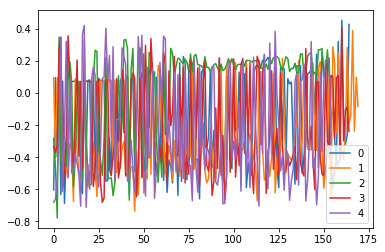

In [185]:
pd.DataFrame(regret.T).iloc[:,0:5].plot()

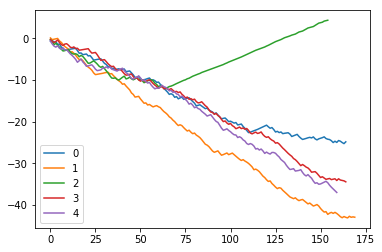

In [196]:
pd.DataFrame(regret.cumsum(axis=1).T).iloc[:,0:5].plot()

In [199]:
regret[2]

array([-0.28261998, -0.46516465, -0.77770871,  0.34839059, -0.43056475,
       -0.53505827, -0.4355283 , -0.45871472,  0.08254541,  0.19685377,
        0.07130247, -0.58476295, -0.40242022, -0.10667707,  0.07324642,
       -0.18241614, -0.53279104,  0.33159883, -0.2583826 , -0.51180431,
       -0.57447558, -0.56643143,  0.07110348,  0.26657987,  0.25945799,
       -0.35003515, -0.41532404, -0.51244364, -0.28060836,  0.22305771,
       -0.52587439, -0.53247192, -0.52820718, -0.63927204, -0.55681827,
       -0.07002479,  0.1079179 , -0.3643995 , -0.1708801 ,  0.32968844,
        0.33389398,  0.27712753, -0.66685856,  0.14333174,  0.27892759,
       -0.38635392, -0.2575494 ,  0.23272196,  0.28188258, -0.5217525 ,
        0.2444641 , -0.48044448, -0.44062798,  0.2538594 ,  0.22420975,
        0.10324184,  0.13288945, -0.26279021, -0.55722338, -0.32807373,
       -0.52398538,  0.23409332, -0.25854086, -0.25901378, -0.20755788,
        0.27884567,  0.24329604,  0.10724329,  0.17071358,  0.21

In [191]:
regret[0].cumsum()

array([ -0.6029349 ,  -0.5069932 ,  -0.90157898,  -0.81229403,
        -1.44357259,  -1.36939389,  -2.05663914,  -2.4312672 ,
        -2.82160366,  -2.74919687,  -2.67738791,  -2.60494448,
        -2.52884856,  -2.45529333,  -2.38400968,  -2.95045147,
        -3.57732289,  -3.5058252 ,  -3.91961646,  -3.84062737,
        -3.75940107,  -4.23282564,  -4.1400049 ,  -4.64939976,
        -5.23071185,  -5.13862097,  -5.06395353,  -4.98670753,
        -4.90675688,  -5.45609599,  -6.00025048,  -6.27746147,
        -6.78791969,  -6.71395277,  -7.2638028 ,  -7.18598995,
        -7.48572254,  -7.41029216,  -7.31445837,  -7.55978491,
        -7.4784847 ,  -7.3652881 ,  -8.00050094,  -7.91130225,
        -7.82676975,  -8.3169258 ,  -8.77216508,  -9.40501267,
        -9.32218654,  -9.1946801 ,  -9.72487882, -10.09505555,
        -9.9348107 ,  -9.82187881,  -9.65813152,  -9.5324945 ,
       -10.05349394,  -9.95422309, -10.18087971, -10.57608431,
       -10.49693002, -11.04070894, -11.41403132, -12.03

In [195]:
[0]

array([ -0.6029349 ,  -0.5069932 ,  -0.90157898,  -0.81229403,
        -1.44357259,  -1.36939389,  -2.05663914,  -2.4312672 ,
        -2.82160366,  -2.74919687,  -2.67738791,  -2.60494448,
        -2.52884856,  -2.45529333,  -2.38400968,  -2.95045147,
        -3.57732289,  -3.5058252 ,  -3.91961646,  -3.84062737,
        -3.75940107,  -4.23282564,  -4.1400049 ,  -4.64939976,
        -5.23071185,  -5.13862097,  -5.06395353,  -4.98670753,
        -4.90675688,  -5.45609599,  -6.00025048,  -6.27746147,
        -6.78791969,  -6.71395277,  -7.2638028 ,  -7.18598995,
        -7.48572254,  -7.41029216,  -7.31445837,  -7.55978491,
        -7.4784847 ,  -7.3652881 ,  -8.00050094,  -7.91130225,
        -7.82676975,  -8.3169258 ,  -8.77216508,  -9.40501267,
        -9.32218654,  -9.1946801 ,  -9.72487882, -10.09505555,
        -9.9348107 ,  -9.82187881,  -9.65813152,  -9.5324945 ,
       -10.05349394,  -9.95422309, -10.18087971, -10.57608431,
       -10.49693002, -11.04070894, -11.41403132, -12.03

In [ ]:
sim_param_vals.f

In [135]:

sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])
# sim_param_vals.fill(np.nan)

In [136]:
sim_param_vals.i

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,0.000000e+00,8.105121e-315,2.823585e-320,NaN,1.121529e-321,1.629693e-311,5.885147e-307,5.833298e-302
1,2.485627e-297,5.832902e-302,6.999569e-283,9.878204e-278,1.971091e-268,3.564562e-306,1.303165e-258,8.560405e-254
2,8.183229e-201,3.632251e-249,8.540430e+151,5.267504e+170,5.834395e+252,8.184330e-85,4.521812e+217,6.240142e-85
3,6.202040e+223,7.874881e+276,2.652926e+180,5.043425e+180,4.360383e+251,3.128566e+180,-9.785451e+197,2.165200e-256
4,5.992670e+175,2.649310e+180,1.137527e+243,6.151189e+72,1.219469e+199,2.164512e+233,3.018741e-321,1.086462e-311
5,2.720066e-307,2.217178e-301,3.561780e-306,2.581611e-306,5.340514e-306,5.795298e-85,2.100532e-301,5.340514e-306
6,7.747500e-297,8.902917e-307,1.930125e-309,2.781342e-309,4.227640e-307,1.392346e+188,6.260633e+250,2.361321e+236
7,-3.630026e+125,6.362952e-295,1.035653e-308,-4.538016e+279,5.831025e+252,9.701583e+189,1.436220e+161,4.963612e+247
8,1.169078e+171,9.302819e+242,1.828129e-19,3.655883e+233,3.406058e-309,4.702992e+170,6.354179e+151,4.824089e+228
9,1.170758e+214,8.894926e+252,4.566638e+44,1.021899e-152,4.824089e+228,1.494902e+248,1.286255e+248,2.456526e+198


In [114]:
sim_param_vals

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
import pandas as pd

In [ ]:
sim_param_vals = pd.DataFrame()

In [106]:
regret = np.load("../../Results/ST/reward_exp_simNum" + str(sim_num_done) + ".npy")
np.nanmean(regret,axis=1).std()


0.76696457194930912

In [111]:

sim_param_vals = pd.DataFrame(np.empty((core_count * len(params) * num_run_through, len(params)+2)),columns=params + ["Mean","Std"])

,N_c_mult,T_c,sig2_mult,gamma,lamb,prior_cov_mult,Mean,Std
0,4.940656e-324,8.105395e-315,2.786036e-320,NaN,4.589877e-311,0.000000e+00,5.328171e+233,3.865989e+233
1,7.872660e+276,9.750238e+199,9.669552e+242,1.943020e+227,5.292743e+199,1.876806e-152,1.237808e-259,4.824089e+228
2,3.526839e+233,1.275872e-152,7.266066e+223,9.073135e+223,9.477512e+170,8.879024e+73,1.792381e-19,2.420724e+232
3,8.963826e+276,2.053355e+190,9.514039e-90,2.875079e+161,6.942939e+193,1.234625e-259,4.909228e+252,4.475938e-91
4,3.475830e+183,4.002475e+151,2.904691e+180,1.382397e-94,1.171231e+166,1.255480e+232,3.933798e-85,1.335206e+228
5,1.459127e-152,1.951348e+227,1.106400e+200,1.507544e+161,1.488903e+195,7.102365e+194,5.292727e+199,1.375626e+214
6,2.168408e+243,2.439005e-154,3.582512e+246,3.624800e+228,7.203547e+159,7.776691e+160,4.224645e-153,2.314616e-152
7,1.276415e-152,5.069241e+252,7.105410e+159,8.564860e+183,1.668280e+243,4.202689e+88,4.572363e+228,8.928922e+271
8,1.133376e-153,8.903854e+252,1.021833e-152,5.292768e+199,5.630967e+175,1.275872e-152,2.057511e-81,1.098008e+248
9,4.497457e+251,3.446189e-85,8.177295e+173,5.852419e+199,1.276164e-152,1.505982e+161,2.612614e+257,5.037346e+180


[0.5, 5, 1.0, 0.9, 1.0, 10.0]

In [83]:
sim_param_vals[0]

array([  0.5,   5. ,   1. ,   0.9,   1. ,  10. ])

In [53]:
np.linspace(0.05,0.9,num=sim_count)

array([ 0.05  ,  0.2625,  0.475 ,  0.6875,  0.9   ])

In [28]:
param_vals

{'N_c_mult': 0.5,
 'T_c': 5,
 'gamma': 0.9,
 'lamb': 1.0,
 'prior_cov_mult': 0.5,
 'sig2_mult': 1.0}

In [38]:
with open("../Testing Scripts/yamls/params0.yaml") as f:
    a =  yaml.load(f)

In [ ]:
"../Testing Scripts/"

In [26]:
np.linspace(min_param_vals[param], max_param_vals[param],num=sim_count).round()

array([  0.,   3.,   5.,   8.,  10.])

In [ ]:
yaml.read

array([ 0.        ,  0.26315789,  0.52631579,  0.78947368,  1.05263158,
        1.31578947,  1.57894737,  1.84210526,  2.10526316,  2.36842105,
        2.63157895,  2.89473684,  3.15789474,  3.42105263,  3.68421053,
        3.94736842,  4.21052632,  4.47368421,  4.73684211,  5.        ])

{'N_c_mult': 0.5,
 'T_c': 5,
 'gamma': 0.9,
 'lamb': 1.0,
 'prior_cov_mult': 0.5,
 'sig2_mult': 1.0}

In [ ]:

sig2_mults = [0.5,1.,2.]
prior_cov_mults = [0.1,0.5,1.,2.]
gammas = [0.8,0.9,0.99,1.]
lambs = [0.1,0.5, 1.,2.]
N_c_mults = [0.25, 0.5,0.75]
T_cs = [5, 10, 20]
